Training läuft auf: cuda
Starte Simulation mit 'Smart Padding' (Wände werden sichtbar) & High Wall Penalty...

--- Simulation mit Step Penalty: -0.1 ---
Episode 0: [-0.75]
Episode 10: [0.1]
Episode 20: [-0.15]
Episode 30: [-0.45]
Episode 40: [-0.54]
Episode 50: [0.01]
Episode 60: [0.0]
Episode 70: [-7.1]
Episode 80: [0.0]
Episode 90: [-0.8]
Episode 100: [-0.48]
Episode 110: [19.57]
Episode 120: [19.95]
Episode 130: [14.57]
Episode 140: [19.08]
Episode 150: [-1.76]
Episode 160: [0.0]
Episode 170: [17.06]
Episode 180: [-0.6]
Episode 190: [-0.7]
Episode 200: [0.0]
Episode 210: [12.18]
Episode 220: [0.0]
Episode 230: [38.28]
Episode 240: [0.1]
Episode 250: [39.94]
Episode 260: [0.0]
Episode 270: [58.71]
Episode 280: [39.7]
Episode 290: [-2.9]
Episode 300: [38.85]
Episode 310: [19.53]
Episode 320: [0.05]
Episode 330: [0.05]
Episode 340: [39.97]
Episode 350: [39.03]
Episode 360: [0.0]
Episode 370: [-0.15]
Episode 380: [37.68]
Episode 390: [0.0]
Episode 400: [72.06]
Episode 410: [-11.25]
Epis

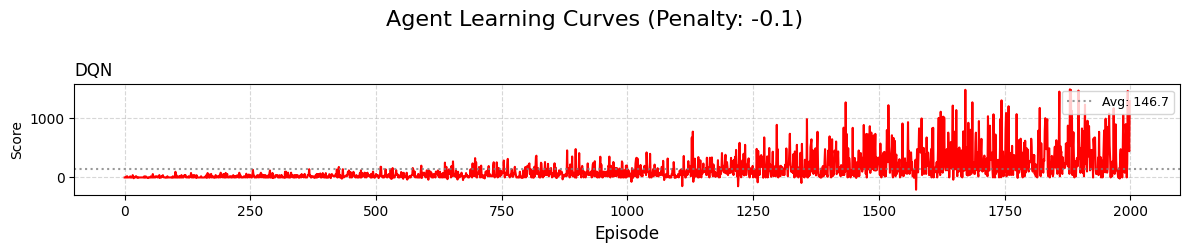

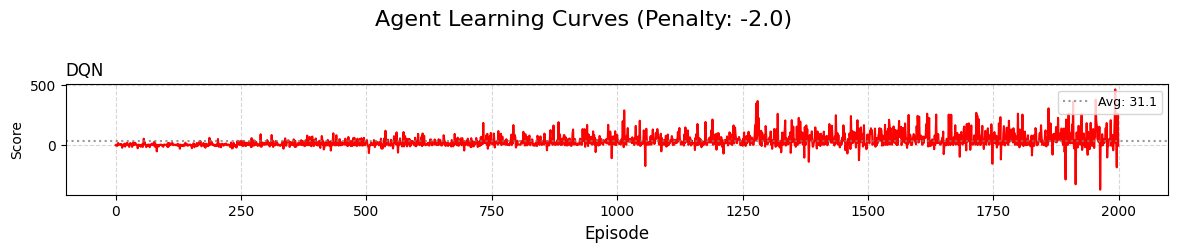

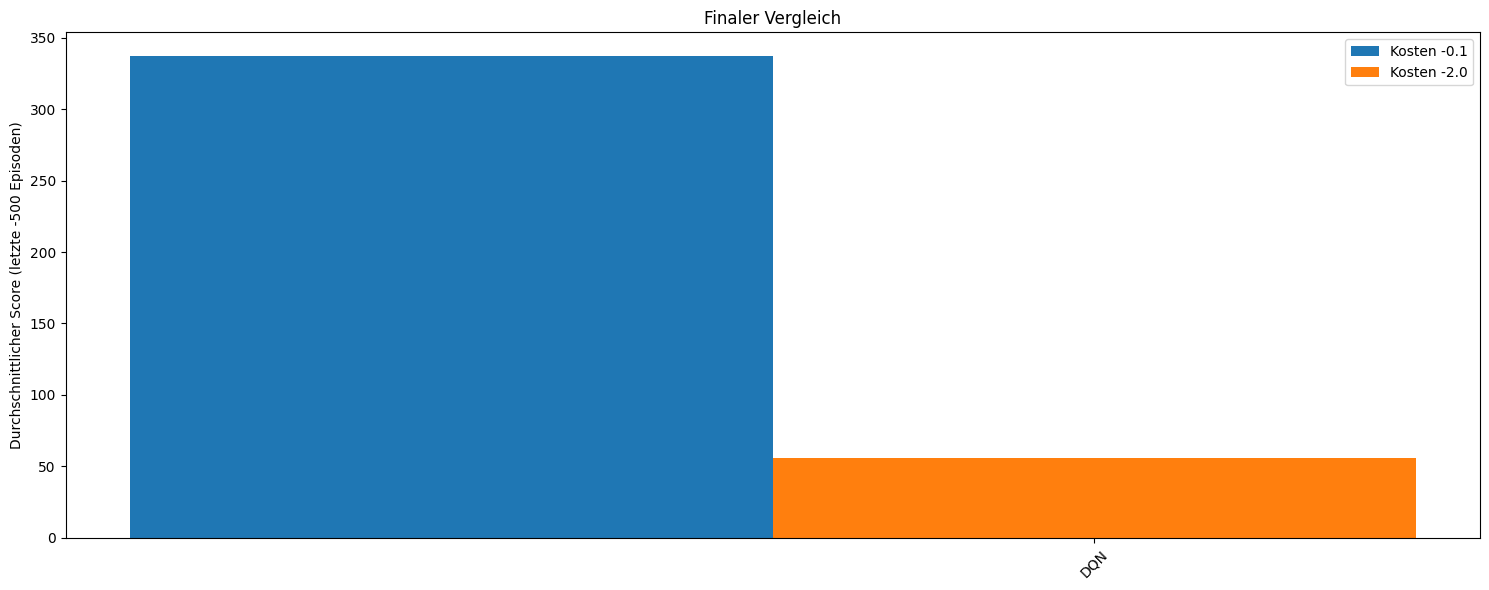

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import display, clear_output
import os

# GPU CHECK 
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training läuft auf: {device}")

# 1. CONFIGURATION 
class Config:
    GRID_WIDTH = 40  
    GRID_HEIGHT = 40
    NUM_RESOURCES = 150
    NUM_OBSTACLES = 25
    AGENT_VIEW_RADIUS = 7
    
    # Simulation Settings
    NUM_EPISODES_PER_SETTING = 2000 
    MAX_STEPS_PER_EPISODE = 250
    
    SEED = 42
    
    # Hyperparameters
    LEARNING_RATE = 0.0002
    GAMMA = 0.99
    REPLAY_MEMORY_SIZE = 50000
    BATCH_SIZE = 64
    EPSILON_START = 1.0
    EPSILON_END = 0.02
    EPSILON_DECAY = 0.9985
    TARGET_UPDATE_FREQ = 20
    
    STEP_PENALTIES = [-0.1,-2.0] 

# 
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

#2. NEURAL NETWORK (DQN) 
class DQN_CNN(nn.Module):
    def __init__(self, input_channels, num_actions):
        super(DQN_CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        dummy_input_size = (2 * Config.AGENT_VIEW_RADIUS + 1)
        conv_out_size = self._get_conv_out_size((input_channels, dummy_input_size, dummy_input_size))
        
        self.fc_layers = nn.Sequential(
            nn.Linear(conv_out_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )

    def _get_conv_out_size(self, shape):
        o = self.conv_layers(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)

# 3. ENVIRONMENT (Standard Action Space)
class GridWorld:
    EMPTY, OBSTACLE, RESOURCE, AGENT = 0, 1, 2, 3
    
    def __init__(self, config, agents, step_penalty=-0.1):
        self.config = config
        self.width = config.GRID_WIDTH
        self.height = config.GRID_HEIGHT
        self.agents = agents
        self.step_penalty = step_penalty
        self.grid = np.full((self.width, self.height), self.EMPTY, dtype=int)
        self.resources_remaining = 0
        
    def _place_objects(self, object_type, count):
        for _ in range(count):
            while True:
                x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
                if self.grid[x, y] == self.EMPTY:
                    self.grid[x, y] = object_type
                    break

    def reset(self):
        self.grid.fill(self.EMPTY)
        self._place_objects(self.OBSTACLE, self.config.NUM_OBSTACLES)
        self._place_objects(self.RESOURCE, self.config.NUM_RESOURCES)
        
        for agent in self.agents:
            agent.reset()
            agent.active = True 
            while True:
                x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
                if self.grid[x, y] == self.EMPTY:
                    agent.pos = (x, y); break
        self.resources_remaining = self.config.NUM_RESOURCES
        return self._get_full_state()

    def _get_full_state(self):
        state = np.zeros((4, self.width, self.height), dtype=np.float32)
        state[self.EMPTY] = (self.grid == self.EMPTY)
        state[self.OBSTACLE] = (self.grid == self.OBSTACLE)
        state[self.RESOURCE] = (self.grid == self.RESOURCE)
        for ag in self.agents:
            if ag.active:
                state[self.AGENT, ag.pos[0], ag.pos[1]] = 1
        return state
    
    # 
    def get_agent_view(self, agent_pos, exclude_self=None):
        x, y = agent_pos
        r = self.config.AGENT_VIEW_RADIUS
        view_size = 2 * r + 1
        
        full_state = self._get_full_state()
        if exclude_self is not None:
            full_state[self.AGENT, exclude_self.pos[0], exclude_self.pos[1]] = 0
            
        # Wir erstellen eine "Leinwand", die größer ist als das Grid
        # Standardmäßig ist alles darauf "OBSTACLE" (Wand)
        # Channel 0 (Empty) = 0
        # Channel 1 (Obstacle) = 1  <-- : Die Welt außerhalb ist Wand!
        # Channel 2 (Resource) = 0
        # Channel 3 (Agent) = 0
        padded_canvas = np.zeros((4, self.width + 2*r, self.height + 2*r), dtype=np.float32)
        padded_canvas[self.OBSTACLE, :, :] = 1.0 
        
        # Das eigentliche Spielfeld in die Mitte kopieren (überschreibt die Standard-Wände dort wo das Feld ist)
        # Wo im Spielfeld "EMPTY" ist, muss im Canvas OBSTACLE auf 0 gesetzt werden.
        # Wir kopieren den full_state einfach hart in die Mitte.
        start_x, start_y = r, r
        padded_canvas[:, start_x:start_x+self.width, start_y:start_y+self.height] = full_state
        
        # Jetzt schneiden wir einfach aus. Da der Rand nun aus "1" im Obstacle-Channel besteht,
        # "sieht" das CNN nun eine Wand am Rand der Welt.
        view = padded_canvas[:, x:x+view_size, y:y+view_size]
        
        return torch.FloatTensor(view).unsqueeze(0)

    def step(self, agent_idx, action):
        agent = self.agents[agent_idx]
        
        if not agent.active:
            return self.get_agent_view(agent.pos), 0, (self.resources_remaining == 0)

        if action == 5: 
            agent.active = False
            return self.get_agent_view(agent.pos), 0, (self.resources_remaining == 0)
            
        px, py = agent.pos
        
        # REWARD SHAPING PRE-CALC 
        min_dist_old = float('inf')
        res_indices = np.argwhere(self.grid == self.RESOURCE)
        if len(res_indices) > 0:
            dists = np.linalg.norm(res_indices - np.array([px, py]), axis=1)
            min_dist_old = np.min(dists)
        
        if hasattr(agent, 'record_step'):
            agent.record_step((px, py))

        # 0: Up, 1: Down, 2: Left, 3: Right, 4: Wait
        dx, dy = 0, 0
        steps_to_take = 0
        
        if 0 <= action <= 3:
            steps_to_take = 1
            if action == 0: dx = -1
            elif action == 1: dx = 1
            elif action == 2: dy = -1
            elif action == 3: dy = 1
        elif action == 4:
            steps_to_take = 0
        
        total_reward = 0
        hit_wall = False
        
        for _ in range(steps_to_take):
            npx, npy = px + dx, py + dy
            
            # WAND KOLLISION LOGIK 
            # Wenn außerhalb des Grids ODER Hindernis
            if not (0 <= npx < self.width and 0 <= npy < self.height) or self.grid[npx, npy] == self.OBSTACLE:
                # Höhere Strafe für Wände damit er es schneller lernt!
                total_reward += -5.0 
                hit_wall = True
                break 
            
            is_occupied = any(ag.active and ag.pos == (npx, npy) for ag in self.agents if ag is not agent)
            if is_occupied:
                total_reward += -2.0 # Kollision mit Agenten
                break
            
            px, py = npx, npy
            total_reward += self.step_penalty 
            
            if self.grid[px, py] == self.RESOURCE:
                total_reward += 10.0
                self.grid[px, py] = self.EMPTY
                self.resources_remaining -= 1
                agent.score += 10.0
        
        agent.pos = (px, py)
        
        # Anti-Zitter Strafe
        is_looping = False
        if hasattr(agent, 'pos_history') and len(agent.pos_history) >= 2:
            if (px, py) == agent.pos_history[-2]:
                total_reward -= 0.9 
                is_looping = True

        # Reward Shaping nur wenn er nicht gegen die Wand gerannt ist
        if total_reward > -4.0 and not hit_wall and not is_looping and min_dist_old != float('inf'):
            res_indices_new = np.argwhere(self.grid == self.RESOURCE)
            if len(res_indices_new) > 0:
                dists_new = np.linalg.norm(res_indices_new - np.array([px, py]), axis=1)
                min_dist_new = np.min(dists_new)
                
                if min_dist_new < min_dist_old:
                    total_reward += 0.2 * (min_dist_old - min_dist_new) 
                elif min_dist_new > min_dist_old:
                    total_reward -= 0.05

        agent.score += total_reward
        
        done = (self.resources_remaining == 0)
        if all(not ag.active for ag in self.agents): done = True
            
        view = self.get_agent_view(agent.pos, exclude_self=agent if isinstance(agent, (SophisticatedHeuristicAgent, CompetitorAgent)) else None)
        return view, total_reward, done

# 4. AGENTEN    
class BaseAgent:
    def __init__(self, agent_id):
        self.agent_id = agent_id; self.pos = (0, 0); self.score = 0; self.active = True
    def reset(self): self.score = 0; self.active = True
    def select_action(self, state, **kwargs): raise NotImplementedError

class RandomAgent(BaseAgent):
    def select_action(self, state, **kwargs): return random.randint(0, 5)

class HeuristicAgent(BaseAgent):
    def select_action(self, state, **kwargs):
        view = state.squeeze(0).numpy(); r = Config.AGENT_VIEW_RADIUS
        res = np.argwhere(view[GridWorld.RESOURCE] == 1)
        if len(res) > 0:
            c = np.array([r, r]); d = np.linalg.norm(res - c, axis=1)
            cl = res[np.argmin(d)]; dx, dy = cl - c
            if abs(dx) > abs(dy): return 0 if dx < 0 else 1
            else: return 2 if dy < 0 else 3
        return random.randint(0, 4) 

class SophisticatedHeuristicAgent(BaseAgent):
    def __init__(self, agent_id, memory_size=10):
        super().__init__(agent_id)
        self.memory = deque(maxlen=memory_size)
    
    def reset(self):
        super().reset()
        self.memory.clear()
        
    def record_step(self, pos):
        # Wird von GridWorld aufgerufen, speichert globalen Pfad
        self.memory.append(pos)

    def select_action(self, state, **kwargs):
        # Setup
        view = state.squeeze(0).numpy()
        r = Config.AGENT_VIEW_RADIUS
        center = np.array([r, r])
        
        # Objekte finden (lokale Koordinaten)
        resources = np.argwhere(view[GridWorld.RESOURCE] == 1)
        opponents = np.argwhere(view[GridWorld.AGENT] == 1)
        # Entferne uns selbst aus der Gegner-Liste (wir stehen in der Mitte)
        opponents = np.array([o for o in opponents if not np.array_equal(o, center)])

        # PRIORITÄT 1: Sichere Ausbeutung 
        if len(resources) > 0:
            # Sortiere Ressourcen nach Distanz zu uns
            dists = np.linalg.norm(resources - center, axis=1)
            sorted_indices = np.argsort(dists)
            sorted_resources = resources[sorted_indices]
            
            for res in sorted_resources:
                my_dist = np.linalg.norm(res - center)
                
                # Ist die Ressource "sicher"? (Kein Gegner ist näher dran)
                is_safe = True
                if len(opponents) > 0:
                    opp_dists = np.linalg.norm(opponents - res, axis=1)
                    min_opp_dist = np.min(opp_dists)
                    if min_opp_dist <= my_dist:
                        is_safe = False
                
                if is_safe:
                    return self._move_towards(center, res)

        # PRIORITÄT 2: Aktive Vermeidung (Flucht)
        if len(opponents) > 0:
            # Finde nächsten Gegner
            opp_dists = np.linalg.norm(opponents - center, axis=1)
            closest_opp = opponents[np.argmin(opp_dists)]
            
            # Wenn Gegner sehr nah ist (z.B. < 2 Felder), fliehe!
            if np.min(opp_dists) <= 2:
                return self._move_away(center, closest_opp)

        # PRIORITÄT 3: Gedächtnisbasierte Exploration (Tabu Search)
        return self._memory_based_random_move()

    def _move_towards(self, current, target):
        dx, dy = target - current
        if abs(dx) > abs(dy): return 0 if dx < 0 else 1 # 0=Up, 1=Down
        else: return 2 if dy < 0 else 3 # 2=Left, 3=Right

    def _move_away(self, current, target):
        # Vektor vom Gegner zu mir = -(Vektor zu Gegner)
        dx, dy = current - target 
        # Wir wollen diesen Abstand vergrößern
        if abs(dx) > abs(dy): return 1 if dx < 0 else 0 # Invertierte Logik zur Flucht
        else: return 3 if dy < 0 else 2 

    def _memory_based_random_move(self):
        # Versuche Züge, die nicht auf Felder führen, wo wir gerade waren
        possible_moves = [0, 1, 2, 3]
        random.shuffle(possible_moves)
        
        best_move = random.randint(0, 4)
        
        for move in possible_moves:
            # Simuliere globalen Schritt
            dx, dy = 0, 0
            if move == 0: dx = -1
            elif move == 1: dx = 1
            elif move == 2: dy = -1
            elif move == 3: dy = 1
            
            next_pos = (self.pos[0] + dx, self.pos[1] + dy)
            
            # Wenn wir dort nicht kürzlich waren, nimm diesen Zug
            if next_pos not in self.memory:
                return move
                
        # Wenn alle blockiert/besucht sind, mach Random (oder Wait)
        return random.randint(0, 4)

class MomentumAgent(BaseAgent):
    def __init__(self, agent_id): super().__init__(agent_id); self.last_move = random.randint(0, 3)
    def select_action(self, state, **kwargs):
        view = state.squeeze(0).numpy(); r = Config.AGENT_VIEW_RADIUS
        if len(np.argwhere(view[GridWorld.RESOURCE] == 1)) > 0:
            return HeuristicAgent(0).select_action(state)
        dr, dc = [(-1,0), (1,0), (0,-1), (0,1)][self.last_move]
        tr, tc = r + dr, r + dc
        # Sicherstellen, dass Momentum nicht aus dem Array greift
        if 0 <= tr < view.shape[1] and 0 <= tc < view.shape[2]:
            if view[GridWorld.OBSTACLE, tr, tc] == 1: self.last_move = random.randint(0, 3) 
        else:
            self.last_move = random.randint(0, 3) # Rand getroffen
        return self.last_move

class BFSAgent(BaseAgent):
    def select_action(self, state, **kwargs):
        view = state.squeeze(0).numpy(); r = Config.AGENT_VIEW_RADIUS; start = (r, r)
        queue = deque([(start, [])]); visited = {start}
        while queue:
            (cr, cc), path = queue.popleft()
            if view[GridWorld.RESOURCE, cr, cc] == 1: return path[0] if path else 4
            for act, (dr, dc) in enumerate([(-1,0),(1,0),(0,-1),(0,1)]):
                nr, nc = cr+dr, cc+dc
                if 0<=nr<view.shape[1] and 0<=nc<view.shape[2] and (nr,nc) not in visited:
                    if view[GridWorld.OBSTACLE, nr, nc] == 0:
                        visited.add((nr, nc)); queue.append(((nr, nc), path + [act]))
        return random.randint(0, 4)

class CompetitorAgent(BaseAgent):
    def select_action(self, state, **kwargs):
        view = state.squeeze(0).numpy()
        r = Config.AGENT_VIEW_RADIUS
        center = np.array([r, r])
        
        resources = np.argwhere(view[GridWorld.RESOURCE] == 1)
        opponents = np.argwhere(view[GridWorld.AGENT] == 1)
        opponents = np.array([o for o in opponents if not np.array_equal(o, center)])
        
        best_target = None
        min_dist = float('inf')
        
        # Wir suchen die beste Ressource, die wir GEWINNEN können
        for res in resources:
            my_dist = np.linalg.norm(res - center)
            
            # Check: Rennen gegen Gegner
            race_won = True
            if len(opponents) > 0:
                # Distanz aller Gegner zu dieser Ressource
                opp_dists = np.linalg.norm(opponents - res, axis=1)
                shortest_opp_dist = np.min(opp_dists)
                
                # Logik aus der Arbeit: Wir ignorieren Ressourcen, 
                # wo ein Gegner näher oder gleich nah dran ist.
                if shortest_opp_dist <= my_dist:
                    race_won = False
            
            if race_won:
                # Wir nehmen die nächste der "gewinnbaren" Ressourcen
                if my_dist < min_dist:
                    min_dist = my_dist
                    best_target = res
        
        if best_target is not None:
            return self._move_towards(center, best_target)
        
        # Fallback: Keine gewinnbare Ressource -> Random oder Warten
        # Um Energie zu sparen (wenn Penalty hoch), könnte man hier warten (4)
        return random.randint(0, 4)

    def _move_towards(self, current, target):
        dx, dy = target - current
        if abs(dx) > abs(dy): return 0 if dx < 0 else 1
        else: return 2 if dy < 0 else 3

class ROIAgent(BaseAgent):
    def __init__(self, agent_id, step_cost): super().__init__(agent_id); self.step_cost = abs(step_cost) 
    def select_action(self, state, **kwargs):
        v = state.squeeze(0).numpy(); r = Config.AGENT_VIEW_RADIUS
        res = np.argwhere(v[GridWorld.RESOURCE] == 1)
        if len(res) > 0:
            d = np.linalg.norm(res - np.array([r,r]), axis=1)
            if 10.0 - (np.min(d) * self.step_cost) > 0: return HeuristicAgent(0).select_action(state)
        if self.step_cost >= 1.5: return 5 
        return random.randint(0, 4)

class DQNAgent(BaseAgent):
    def __init__(self, agent_id, state_shape, action_space_size, config):
        super().__init__(agent_id)
        self.config = config
        self.action_space_size = action_space_size 
        
        # Gedächtnis für Anti-Zitter
        self.pos_history = deque(maxlen=20) 

        self.policy_net = DQN_CNN(state_shape[0], action_space_size).to(device)
        self.target_net = DQN_CNN(state_shape[0], action_space_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=config.LEARNING_RATE)
        self.replay_memory = deque(maxlen=config.REPLAY_MEMORY_SIZE)
        self.epsilon = config.EPSILON_START

    def reset(self):
        super().reset()
        self.pos_history.clear() 

    def record_step(self, pos):
        self.pos_history.append(pos)

    def select_action(self, state, **kwargs):
        if random.random() > self.epsilon:
            with torch.no_grad():
                return self.policy_net(state.to(device)).max(1)[1].item()
        else:
            return random.randint(0, self.action_space_size - 1)

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_memory.append((state, torch.tensor([[action]]), torch.tensor([reward]), next_state, torch.tensor([done])))

    def train(self):
        if len(self.replay_memory) < self.config.BATCH_SIZE: return
        transitions = random.sample(self.replay_memory, self.config.BATCH_SIZE)
        batch = list(zip(*transitions))
        
        state_batch = torch.cat(batch[0]).to(device)
        action_batch = torch.cat(batch[1]).to(device)
        reward_batch = torch.cat(batch[2]).to(device)
        next_state_batch = torch.cat(batch[3]).to(device)
        done_batch = torch.cat(batch[4]).to(device)

        q_values = self.policy_net(state_batch).gather(1, action_batch)
        next_state_q_values = self.target_net(next_state_batch).max(1)[0].detach()
        expected_q_values = (next_state_q_values * self.config.GAMMA * (1 - done_batch.float())) + reward_batch
        
        loss = nn.functional.smooth_l1_loss(q_values, expected_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_epsilon(self):
        if self.epsilon > self.config.EPSILON_END: self.epsilon *= self.config.EPSILON_DECAY
    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

#PLOT
def plot_and_save_learning_curves(scores_history, agent_names, penalty):
    num_agents = len(agent_names)
    scores_by_agent = list(zip(*scores_history))
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'cyan', 'magenta', 'brown']
    fig, axes = plt.subplots(nrows=num_agents, ncols=1, figsize=(12, 2.5 * num_agents), sharex=True)
    if num_agents == 1: axes = [axes]
    for i, ax in enumerate(axes):
        ax.plot(scores_by_agent[i], color=colors[i % len(colors)], linewidth=1.5)
        ax.set_title(f'{agent_names[i]}', fontsize=12, loc='left')
        ax.set_ylabel('Score')
        ax.grid(True, linestyle='--', alpha=0.5)
        avg = np.mean(scores_by_agent[i])
        ax.axhline(y=avg, color='gray', linestyle=':', alpha=0.8, label=f'Avg: {avg:.1f}')
        ax.legend(loc='upper right', fontsize=9)
    axes[-1].set_xlabel('Episode', fontsize=12)
    fig.suptitle(f'Agent Learning Curves (Penalty: {penalty})', fontsize=16, y=0.99)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    filename = f"Learning_Curve_Penalty_{penalty}_subplots.png"
    plt.savefig(filename)
    print(f"Grafik gespeichert: {filename}")
    # plt.show() # Optional bei Remote

# MAIN SIMULATION LOOP 
config = Config()
results = {} 

print("Starte Simulation mit 'Smart Padding' (Wände werden sichtbar) & High Wall Penalty...")

for penalty in config.STEP_PENALTIES:
    set_seed(config.SEED)
    print(f"\n Simulation mit Step Penalty: {penalty} ")
    
    state_shape = (4, 2*config.AGENT_VIEW_RADIUS+1, 2*config.AGENT_VIEW_RADIUS+1)
    
    # DQN mit 6 Aktionen (0-5: Up, Down, Left, Right, Wait, )
    dqn = DQNAgent(0, state_shape, 6, config) 
    
    #simple = HeuristicAgent(1)
    #rnd = RandomAgent(2)
    #soph = SophisticatedHeuristicAgent(3)
    #mom = MomentumAgent(4)
    #comp = CompetitorAgent(6)
    #roi = ROIAgent(7, step_cost=penalty)
    
    #agents = [dqn, simple, rnd, soph, mom, comp, roi]
    agents = [dqn]

    #agent_names = ["DQN", "Simple", "Random", "Sophist.", "Momentum", "Competitor", "ROI"]
    agent_names = ["DQN"]

    
    env = GridWorld(config, agents, step_penalty=penalty)
    
    scores_history = []
    
    for ep in range(config.NUM_EPISODES_PER_SETTING):
        env.reset()
        for step in range(config.MAX_STEPS_PER_EPISODE):
            indices = list(range(len(agents)))
            random.shuffle(indices)
            for i in indices:
                agent = agents[i]
                if not agent.active: continue
                
                exclude = agent if isinstance(agent, (SophisticatedHeuristicAgent, CompetitorAgent)) else None
                view = env.get_agent_view(agent.pos, exclude_self=exclude)
                if isinstance(agent, ROIAgent): agent.step_cost = abs(penalty)
                
                action = agent.select_action(view)
                next_view, reward, done = env.step(i, action)
                
                if isinstance(agent, DQNAgent):
                    agent.store_transition(view, action, reward, next_view, done)
                    agent.train()
            if done: break
        
        dqn.update_epsilon()
        if ep % config.TARGET_UPDATE_FREQ == 0: dqn.update_target()
        
        scores = [float(round(ag.score,2)) for ag in agents] # Clean Float Output
        scores_history.append(scores)
        if ep % 10 == 0: print(f"Episode {ep}: {scores}")

    fenster = - int((0.25 * config.NUM_EPISODES_PER_SETTING))
    results[penalty] = np.mean(scores_history[fenster:], axis=0)
    plot_and_save_learning_curves(scores_history, agent_names, penalty)

# 6. VISUALIZATION 
plt.figure(figsize=(15, 6))
x = np.arange(len(agent_names))
width = 0.25
for i, penalty in enumerate(config.STEP_PENALTIES):
    plt.bar(x + i*width, results[penalty], width, label=f'Kosten {penalty}')
plt.ylabel(f'Durchschnittlicher Score (letzte {fenster} Episoden)')
plt.title('Finaler Vergleich')
plt.xticks(x + width, agent_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(f"Final_Comparison_Shaped.png")
print("Grafik gespeichert: Final_Comparison_Shaped.png")

# SAVE MODEL
torch.save(dqn.policy_net.state_dict(), "drqn_weights_3_zitter_strafe.pth")
print("Modell erfolgreich gespeichert als 'drqn_weights.pth'")

try:
    from google.colab import files
    print("Download wird vorbereitet...")
    files.download("Final_Comparison_Shaped.png")
    files.download("drqn_weights.pth") 
except ImportError:
    pass

In [ ]:
import pygame
import numpy as np
import torch
import torch.nn as nn
import random
import os
import sys
from collections import deque


# EINSTELLUNGEN

MODEL_FILE = "drqn_weights.pth" 

# Standardwerte beim Start
START_PENALTY = -2.0
START_RESOURCES = 150
START_FPS = 10
START_MAX_STEPS = 250 

# Farben
COLOR_BG = (30, 30, 30)
COLOR_SIDEBAR = (50, 50, 50)
COLOR_BTN = (70, 70, 70)
COLOR_BTN_HOVER = (100, 100, 100)
COLOR_TEXT = (255, 255, 255)
COLOR_ACCENT = (255, 215, 0) # Gold
COLOR_ALERT = (255, 50, 50)  # Rot für Game Over


# 1. KONFIGURATION

class Config:
    GRID_WIDTH = 40
    GRID_HEIGHT = 40
    NUM_RESOURCES = START_RESOURCES
    NUM_OBSTACLES = 40
    AGENT_VIEW_RADIUS = 7
    AGENT_VIEW_SIZE = (2 * AGENT_VIEW_RADIUS + 1)


# 2. NETZWERK

class DQN_Architecture(nn.Module):
    def __init__(self, input_channels, num_actions):
        super(DQN_Architecture, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        dummy_input_size = Config.AGENT_VIEW_SIZE
        o = self.conv_layers(torch.zeros(1, input_channels, dummy_input_size, dummy_input_size))
        conv_out_size = int(np.prod(o.size()))
        
        self.fc_layers = nn.Sequential(
            nn.Linear(conv_out_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv_layers(x)
        x = x.view(batch_size, -1) 
        return self.fc_layers(x)



# 3. UMGEBUNG (STANDARD 6 ACTIONS)

class GridWorld:
    EMPTY, OBSTACLE, RESOURCE, AGENT = 0, 1, 2, 3
    
    def __init__(self, config, agents, step_penalty):
        self.config = config
        self.width = config.GRID_WIDTH
        self.height = config.GRID_HEIGHT
        self.agents = agents
        self.step_penalty = step_penalty
        self.grid = np.full((self.width, self.height), self.EMPTY, dtype=int)
        self.resources_remaining = 0
        
    def _place_objects(self, object_type, count):
        for _ in range(count):
            while True:
                x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
                if self.grid[x, y] == self.EMPTY:
                    self.grid[x, y] = object_type
                    break

    def reset(self):
        self.grid.fill(self.EMPTY)
        self._place_objects(self.OBSTACLE, self.config.NUM_OBSTACLES)
        self._place_objects(self.RESOURCE, self.config.NUM_RESOURCES)
        self.resources_remaining = self.config.NUM_RESOURCES
        for agent in self.agents:
            agent.reset()
            while True:
                x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
                if self.grid[x, y] == self.EMPTY:
                    agent.pos = (x, y); break
        
    def get_agent_view(self, agent_pos, exclude_self=None):
        x, y = agent_pos
        r = self.config.AGENT_VIEW_RADIUS
        
        # Wir nutzen die Logik aus dem Training (Wände sichtbar machen)
        # Wir erstellen eine "Leinwand", die größer ist als das Grid
        # Standardmäßig ist alles darauf "OBSTACLE" (Wand = Channel 1)
        padded_canvas = np.zeros((4, self.width + 2*r, self.height + 2*r), dtype=np.float32)
        padded_canvas[self.OBSTACLE, :, :] = 1.0 
        
        # Full State holen
        full_state = np.zeros((4, self.width, self.height), dtype=np.float32)
        full_state[self.EMPTY] = (self.grid == self.EMPTY)
        full_state[self.OBSTACLE] = (self.grid == self.OBSTACLE)
        full_state[self.RESOURCE] = (self.grid == self.RESOURCE)
        for ag in self.agents:
            if ag.active and ag is not exclude_self:
                full_state[self.AGENT, ag.pos[0], ag.pos[1]] = 1

        # In die Mitte kopieren
        start_x, start_y = r, r
        padded_canvas[:, start_x:start_x+self.width, start_y:start_y+self.height] = full_state
        
        # Ausschneiden
        view = padded_canvas[:, x:x+2*r+1, y:y+2*r+1]
        return torch.FloatTensor(view).unsqueeze(0)

    def step(self, agent_idx, action):
        agent = self.agents[agent_idx]
        if not agent.active: return
        
        # 
        # 
        # STANDARD ACTION MAPPING (6 Actions) 
        # 0: Up
        # 1: Down
        # 2: Left
        # 3: Right
        # 4: Wait
        # 5: Exit
        
        if action == 5: 
            agent.active = False; return

        dx, dy = 0, 0
        
        if action == 0: dx = -1
        elif action == 1: dx = 1
        elif action == 2: dy = -1
        elif action == 3: dy = 1
        # Action 4 is Wait (dx=0, dy=0)

        px, py = agent.pos
        npx, npy = px + dx, py + dy
        
        # Logik für einen einzelnen Schritt
        
        # 1. Wände / Grenzen prüfen
        if not (0 <= npx < self.width and 0 <= npy < self.height) or self.grid[npx, npy] == self.OBSTACLE:
            agent.score += -5.0 # Harte Strafe wie im Training
            # Keine Bewegung
            return
        
        # 2. Gegner prüfen
        occupied = any(ag.active and ag.pos == (npx, npy) for ag in self.agents if ag is not agent)
        if occupied:
            agent.score += -2.0
            # Keine Bewegung
            return
            
        # 3. Bewegung ausführen
        px, py = npx, npy
        agent.score += self.step_penalty
        
        # 4. Ressource sammeln
        if self.grid[px, py] == self.RESOURCE:
            agent.score += 10.0
            self.grid[px, py] = self.EMPTY
            self.resources_remaining -= 1
    
        agent.pos = (px, py)


# AGENTEN

class BaseAgent:
    def __init__(self, agent_id): self.agent_id = agent_id; self.pos = (0,0); self.score = 0; self.active = True
    def reset(self): self.score = 0; self.active = True
    def select_action(self, view): raise NotImplementedError

class RandomAgent(BaseAgent):
    def select_action(self, view): return random.randint(0, 5)

class HeuristicAgent(BaseAgent):
    def select_action(self, view):
        view = view.squeeze(0).numpy(); r = Config.AGENT_VIEW_RADIUS
        res = np.argwhere(view[GridWorld.RESOURCE] == 1)
        if len(res) > 0:
            center = np.array([r, r]); dists = np.linalg.norm(res - center, axis=1)
            closest = res[np.argmin(dists)]; dx, dy = closest - center
            if abs(dx) > abs(dy): return 0 if dx < 0 else 1
            else: return 2 if dy < 0 else 3
        return random.randint(0, 4)

class MomentumAgent(BaseAgent):
    def __init__(self, agent_id): super().__init__(agent_id); self.last = 0
    def select_action(self, view):
        v = view.squeeze(0).numpy(); r = Config.AGENT_VIEW_RADIUS
        if len(np.argwhere(v[GridWorld.RESOURCE] == 1)) > 0: return HeuristicAgent(0).select_action(view)
        dr, dc = [(-1,0), (1,0), (0,-1), (0,1)][self.last]
        tr, tc = r + dr, r + dc
        # Check bounds for momentum
        if 0 <= tr < v.shape[1] and 0 <= tc < v.shape[2]:
             if v[GridWorld.OBSTACLE, tr, tc] == 1: self.last = random.randint(0,3)
        else:
             self.last = random.randint(0,3)
        return self.last

class BFSAgent(BaseAgent):
    def select_action(self, view):
        v = view.squeeze(0).numpy(); r = Config.AGENT_VIEW_RADIUS; start = (r, r)
        queue = deque([(start, [])]); visited = {start}
        while queue:
            (cr, cc), path = queue.popleft()
            if v[GridWorld.RESOURCE, cr, cc] == 1: return path[0] if path else 4
            for act, (dr, dc) in enumerate([(-1,0),(1,0),(0,-1),(0,1)]):
                nr, nc = cr+dr, cc+dc
                if 0<=nr<v.shape[1] and 0<=nc<v.shape[2] and (nr,nc) not in visited:
                    if v[GridWorld.OBSTACLE, nr, nc] == 0:
                        visited.add((nr, nc)); queue.append(((nr, nc), path + [act]))
        return random.randint(0, 4)

class CompetitorAgent(BaseAgent):
    def select_action(self, state, **kwargs):
        view = state.squeeze(0).numpy()
        r = Config.AGENT_VIEW_RADIUS
        center = np.array([r, r])
        
        resources = np.argwhere(view[GridWorld.RESOURCE] == 1)
        opponents = np.argwhere(view[GridWorld.AGENT] == 1)
        opponents = np.array([o for o in opponents if not np.array_equal(o, center)])
        
        best_target = None
        min_dist = float('inf')
        
        # Wir suchen die beste Ressource, die wir GEWINNEN können
        for res in resources:
            my_dist = np.linalg.norm(res - center)
            
            # Check: Rennen gegen Gegner
            race_won = True
            if len(opponents) > 0:
                # Distanz aller Gegner zu dieser Ressource
                opp_dists = np.linalg.norm(opponents - res, axis=1)
                shortest_opp_dist = np.min(opp_dists)
                
                # Logik aus der Arbeit: Wir ignorieren Ressourcen, 
                # wo ein Gegner näher oder gleich nah dran ist.
                if shortest_opp_dist <= my_dist:
                    race_won = False
            
            if race_won:
                # Wir nehmen die nächste der "gewinnbaren" Ressourcen
                if my_dist < min_dist:
                    min_dist = my_dist
                    best_target = res
        
        if best_target is not None:
            return self._move_towards(center, best_target)
        
        # Fallback: Keine gewinnbare Ressource -> Random oder Warten
        # Um Energie zu sparen (wenn Penalty hoch), könnte man hier warten (4)
        return random.randint(0, 4)

    def _move_towards(self, current, target):
        dx, dy = target - current
        if abs(dx) > abs(dy): return 0 if dx < 0 else 1
        else: return 2 if dy < 0 else 3

class ROIAgent(BaseAgent):
    def __init__(self, agent_id, cost): super().__init__(agent_id); self.cost = abs(cost)
    def update_cost(self, new_cost): self.cost = abs(new_cost)
    def select_action(self, view):
        v = view.squeeze(0).numpy(); r = Config.AGENT_VIEW_RADIUS; center = np.array([r, r])
        res = np.argwhere(v[GridWorld.RESOURCE] == 1)
        if len(res) > 0:
            d = np.linalg.norm(res - center, axis=1)
            if 10.0 - (np.min(d) * self.cost) > 0:
                return HeuristicAgent(0).select_action(view)
        if self.cost >= 1.5: return 5 # EXIT 
        return random.randint(0, 4)

class SophisticatedHeuristicAgent(BaseAgent):
    def __init__(self, agent_id, memory_size=10):
        super().__init__(agent_id)
        self.memory = deque(maxlen=memory_size)
    
    def reset(self):
        super().reset()
        self.memory.clear()
        
    def record_step(self, pos):
        # Wird von GridWorld aufgerufen, speichert globalen Pfad
        self.memory.append(pos)

    def select_action(self, state, **kwargs):
        # Setup
        view = state.squeeze(0).numpy()
        r = Config.AGENT_VIEW_RADIUS
        center = np.array([r, r])
        
        # Objekte finden (lokale Koordinaten)
        resources = np.argwhere(view[GridWorld.RESOURCE] == 1)
        opponents = np.argwhere(view[GridWorld.AGENT] == 1)
        # Entferne uns selbst aus der Gegner-Liste (wir stehen in der Mitte)
        opponents = np.array([o for o in opponents if not np.array_equal(o, center)])

        # PRIO1: Sichere Ausbeutung 
        if len(resources) > 0:
            # Sortiere Ressourcen nach Distanz zu uns
            dists = np.linalg.norm(resources - center, axis=1)
            sorted_indices = np.argsort(dists)
            sorted_resources = resources[sorted_indices]
            
            for res in sorted_resources:
                my_dist = np.linalg.norm(res - center)
                
                # Ist die Ressource "sicher"? (Kein Gegner ist näher dran)
                is_safe = True
                if len(opponents) > 0:
                    opp_dists = np.linalg.norm(opponents - res, axis=1)
                    min_opp_dist = np.min(opp_dists)
                    if min_opp_dist <= my_dist:
                        is_safe = False
                
                if is_safe:
                    return self._move_towards(center, res)

        # PRIO 2: Aktive Vermeidung (Flucht) 
        if len(opponents) > 0:
            # Finde nächsten Gegner
            opp_dists = np.linalg.norm(opponents - center, axis=1)
            closest_opp = opponents[np.argmin(opp_dists)]
            
            # Wenn Gegner sehr nah ist (z.B. < 2 Felder), fliehe!
            if np.min(opp_dists) <= 2:
                return self._move_away(center, closest_opp)

        # PRIORITÄT 3: Gedächtnisbasierte Exploration (Tabu Search) 
        return self._memory_based_random_move()

    def _move_towards(self, current, target):
        dx, dy = target - current
        if abs(dx) > abs(dy): return 0 if dx < 0 else 1 # 0=Up, 1=Down
        else: return 2 if dy < 0 else 3 # 2=Left, 3=Right

    def _move_away(self, current, target):
        # Vektor vom Gegner zu mir = -(Vektor zu Gegner)
        dx, dy = current - target 
        # Wir wollen diesen Abstand vergrößern
        if abs(dx) > abs(dy): return 1 if dx < 0 else 0 # Invertierte Logik zur Flucht
        else: return 3 if dy < 0 else 2 

    def _memory_based_random_move(self):
        # Versuche Züge, die nicht auf Felder führen, wo wir gerade waren
        possible_moves = [0, 1, 2, 3]
        random.shuffle(possible_moves)
        
        best_move = random.randint(0, 4)
        
        for move in possible_moves:
            # Simuliere globalen Schritt
            dx, dy = 0, 0
            if move == 0: dx = -1
            elif move == 1: dx = 1
            elif move == 2: dy = -1
            elif move == 3: dy = 1
            
            next_pos = (self.pos[0] + dx, self.pos[1] + dy)
            
            # Wenn wir dort nicht kürzlich waren, nimm diesen Zug
            if next_pos not in self.memory:
                return move
                
        # Wenn alle blockiert/besucht sind, mach Random (oder Wait)
        return random.randint(0, 4)

# TRAINED AGENT
class TrainedAgent(BaseAgent):
    def __init__(self, agent_id, model_path):
        super().__init__(agent_id)
        # 6 Actions!
        self.net = DQN_Architecture(4, 6) 
        
        self.pos_history = deque(maxlen=4)
        self.stuck_counter = 0
        
        if os.path.exists(model_path):
            try:
                self.net.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
                print(f"Modell geladen!")
                self.net.eval()
            except Exception as e:
                print(f"Fehler: {e}")
        else:
            print(f"Datei fehlt: {model_path}")

    def select_action(self, view):
        # 1. Reflex (Greedy)
        v_np = view.squeeze(0).numpy(); r = Config.AGENT_VIEW_RADIUS
        neighbors = [(0, r-1, r), (1, r+1, r), (2, r, r-1), (3, r, r+1)]
        random.shuffle(neighbors)
        for action, nx, ny in neighbors:
            if v_np[GridWorld.RESOURCE, nx, ny] == 1: return action

        # 2. Netz
        if len(view.shape) == 3: view = view.unsqueeze(0)
        with torch.no_grad():
            q_values = self.net(view)
            
        # 3. Anti-Wackel
        self.pos_history.append(self.pos)
        if len(self.pos_history) >= 3 and self.pos_history[-1] == self.pos_history[-3]:
            self.stuck_counter += 1
        else:
            self.stuck_counter = 0
            
        if self.stuck_counter > 2:
            self.stuck_counter = 0
            # Zufallsschritt aus den einfachen Aktionen (0-3)
            return random.randint(0, 3) 

        return q_values.max(1)[1].item()


# 5. UI & VISUALISIERUNG

CELL_SIZE = 15
SIDEBAR_WIDTH = 250
AGENT_COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 0, 255), 
                (255, 165, 0), (0, 255, 255), (128, 0, 128), (139, 69, 19)]

class Button:
    def __init__(self, x, y, w, h, text, callback, args=None):
        self.rect = pygame.Rect(x, y, w, h)
        self.text = text
        self.callback = callback
        self.args = args
        self.hovered = False

    def draw(self, screen, font):
        col = COLOR_BTN_HOVER if self.hovered else COLOR_BTN
        pygame.draw.rect(screen, col, self.rect, border_radius=5)
        pygame.draw.rect(screen, (150,150,150), self.rect, 1, border_radius=5)
        txt_surf = font.render(self.text, True, COLOR_TEXT)
        txt_rect = txt_surf.get_rect(center=self.rect.center)
        screen.blit(txt_surf, txt_rect)

    def check_hover(self, mouse_pos): self.hovered = self.rect.collidepoint(mouse_pos)
    def check_click(self, mouse_pos):
        if self.rect.collidepoint(mouse_pos):
            if self.args is not None: self.callback(self.args)
            else: self.callback()

class InteractiveGame:
    def __init__(self, env, agent_names):
        self.env = env
        self.agent_names = agent_names
        pygame.init()
        self.width = env.width * CELL_SIZE + SIDEBAR_WIDTH
        self.height = env.height * CELL_SIZE
        self.screen = pygame.display.set_mode((self.width, self.height))
        self.clock = pygame.time.Clock()
        self.font = pygame.font.SysFont("Arial", 14)
        self.title_font = pygame.font.SysFont("Arial", 18, bold=True)
        
        # State
        self.paused = False
        self.game_over = False
        self.target_fps = START_FPS
        self.target_res = START_RESOURCES
        self.target_penalty = START_PENALTY
        
        # Steps Counter
        self.max_steps = START_MAX_STEPS
        self.current_step = 0
        
        self.buttons = []
        self.setup_ui()

    def setup_ui(self):
        bx = self.env.width * CELL_SIZE + 20
        by = 350 
        
        def change_fps(d): self.target_fps = max(1, min(60, self.target_fps + d))
        def change_res(d): self.target_res = max(10, min(500, self.target_res + d))
        def change_pen(d): self.target_penalty = round(min(0.0, self.target_penalty + d), 1)
        def change_steps(d): self.max_steps = max(50, min(2000, self.max_steps + d))
        
        # Controls
        self.buttons.append(Button(bx, by, 30, 25, "-", change_fps, -2))
        self.buttons.append(Button(bx+120, by, 30, 25, "+", change_fps, 2))
        by += 40
        self.buttons.append(Button(bx, by, 30, 25, "-", change_res, -25))
        self.buttons.append(Button(bx+120, by, 30, 25, "+", change_res, 25))
        by += 40
        self.buttons.append(Button(bx, by, 30, 25, "-", change_pen, -0.1))
        self.buttons.append(Button(bx+120, by, 30, 25, "+", change_pen, 0.1))
        by += 40
        self.buttons.append(Button(bx, by, 30, 25, "-", change_steps, -50))
        self.buttons.append(Button(bx+120, by, 30, 25, "+", change_steps, 50))
        by += 50
        self.buttons.append(Button(bx, by, 150, 40, "APPLY & RESET", self.restart_game))

    def restart_game(self):
        self.env.config.NUM_RESOURCES = self.target_res
        self.env.step_penalty = self.target_penalty
        for ag in self.env.agents:
            if hasattr(ag, 'update_cost'): ag.update_cost(self.target_penalty)
        
        self.env.reset()
        self.current_step = 0
        self.game_over = False
        self.paused = False
        print(f"Reset: Steps={self.max_steps}, Pen={self.target_penalty}")

    def draw_ui(self):
        sb_rect = pygame.Rect(self.env.width*CELL_SIZE, 0, SIDEBAR_WIDTH, self.height)
        pygame.draw.rect(self.screen, COLOR_SIDEBAR, sb_rect)
        pygame.draw.line(self.screen, (100,100,100), (self.env.width*CELL_SIZE, 0), (self.env.width*CELL_SIZE, self.height))
        
        mx, my = pygame.mouse.get_pos()
        x_off = self.env.width*CELL_SIZE + 20
        y = 10
        
        # Header
        self.screen.blit(self.title_font.render("LIVE DASHBOARD", True, COLOR_ACCENT), (x_off, y)); y += 30
        
        # Step Counter
        step_col = COLOR_ALERT if self.current_step >= self.max_steps else COLOR_TEXT
        self.screen.blit(self.font.render(f"Step: {self.current_step} / {self.max_steps}", True, step_col), (x_off, y))
        y += 20
        
        if self.game_over:
            self.screen.blit(self.title_font.render("TIME'S UP!", True, COLOR_ALERT), (x_off, y))
        elif self.paused:
            self.screen.blit(self.title_font.render("PAUSED", True, COLOR_ACCENT), (x_off, y))
        y += 30

        # Ranking
        ranking = sorted(enumerate(self.env.agents), key=lambda x: x[1].score, reverse=True)
        for idx, (orig_idx, ag) in enumerate(ranking):
            col = AGENT_COLORS[orig_idx % 8]
            name = self.agent_names[orig_idx]
            stat = " (EXIT)" if not ag.active else ""
            txt = f"{name}: {ag.score:.1f}{stat}"
            self.screen.blit(self.font.render(txt, True, col), (x_off, y)); y += 20
            
        y += 10
        self.screen.blit(self.font.render(f"Resources Left: {self.env.resources_remaining}", True, COLOR_TEXT), (x_off, y))
        
        # Labels
        y_ctrl = 350
        self.screen.blit(self.font.render(f"Speed: {self.target_fps} FPS", True, COLOR_TEXT), (x_off+40, y_ctrl+5)); y_ctrl += 40
        self.screen.blit(self.font.render(f"Res: {self.target_res}", True, COLOR_TEXT), (x_off+40, y_ctrl+5)); y_ctrl += 40
        col_pen = (255, 100, 100) if self.target_penalty < 0 else (100, 255, 100)
        self.screen.blit(self.font.render(f"Cost: {self.target_penalty}", True, col_pen), (x_off+40, y_ctrl+5)); y_ctrl += 40
        self.screen.blit(self.font.render(f"Max: {self.max_steps}", True, COLOR_TEXT), (x_off+40, y_ctrl+5))

        for btn in self.buttons:
            btn.check_hover((mx, my))
            btn.draw(self.screen, self.font)

    def run(self):
        running = True
        while running:
            for event in pygame.event.get():
                if event.type == pygame.QUIT: running = False
                if event.type == pygame.MOUSEBUTTONDOWN:
                    if event.button == 1:
                        for btn in self.buttons: btn.check_click(event.pos)
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_SPACE: self.paused = not self.paused

            if not self.paused and not self.game_over and self.env.resources_remaining > 0:
                if self.current_step >= self.max_steps:
                    self.game_over = True
                    print("Simulation beendet: Max Steps erreicht.")
                else:
                    self.current_step += 1
                    indices = list(range(len(self.env.agents)))
                    random.shuffle(indices)
                    
                    for i in indices:
                        agent = self.env.agents[i]
                        if not agent.active: continue
                        exclude = agent if isinstance(agent, (SophisticatedHeuristicAgent, CompetitorAgent)) else None
                        view = self.env.get_agent_view(agent.pos, exclude_self=exclude)
                        action = agent.select_action(view)
                        self.env.step(i, action)
            
            self.screen.fill(COLOR_BG)
            # Grid
            for x in range(self.env.width):
                for y in range(self.env.height):
                    rect = pygame.Rect(y*CELL_SIZE, x*CELL_SIZE, CELL_SIZE, CELL_SIZE)
                    val = self.env.grid[x, y]
                    if val == GridWorld.OBSTACLE: pygame.draw.rect(self.screen, (100,100,100), rect)
                    elif val == GridWorld.RESOURCE: 
                        c = (y*CELL_SIZE + CELL_SIZE//2, x*CELL_SIZE + CELL_SIZE//2)
                        pygame.draw.circle(self.screen, (255,215,0), c, CELL_SIZE//3)
                    pygame.draw.rect(self.screen, (40,40,40), rect, 1)
            
            # Agents
            for i, ag in enumerate(self.env.agents):
                if not ag.active: continue
                r = pygame.Rect(ag.pos[1]*CELL_SIZE, ag.pos[0]*CELL_SIZE, CELL_SIZE, CELL_SIZE)
                col = AGENT_COLORS[i % 8]
                pygame.draw.rect(self.screen, col, r, border_radius=3)
                pygame.draw.rect(self.screen, (255,255,255), r, 1, border_radius=3)

            self.draw_ui()
            pygame.display.flip()
            self.clock.tick(self.target_fps)

        pygame.quit()


if __name__ == "__main__":
    config = Config()
    state_shape = (4, 2*config.AGENT_VIEW_RADIUS+1, 2*config.AGENT_VIEW_RADIUS+1)
    
    dqn = TrainedAgent(0, MODEL_FILE)
    simple = HeuristicAgent(1); rnd = RandomAgent(2); soph = SophisticatedHeuristicAgent(3)
    mom = MomentumAgent(4); bfs = BFSAgent(5); comp = CompetitorAgent(6)
    roi = ROIAgent(7, 2)
    
    agents = [dqn, simple, rnd, soph, mom,  comp, roi] #bfs,
    names = ["DRQN (AI)", "Simple", "Random", "Sophist.", "Momentum", "Competitor", "ROI"] #"BFS (Robot)"
    
    env = GridWorld(config, agents, step_penalty=START_PENALTY)
    env.reset()
    print("Starte Dashboard...")
    
    game = InteractiveGame(env, names)
    game.run()

C:\Users\yahya\AppData\Local\Temp\ipykernel_81628\727416384.py:402: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(model_path, map_locatio

Modell geladen!
Starte Dashboard...
Reset: Steps=250, Pen=-0.1
Simulation beendet: Max Steps erreicht.
Reset: Steps=250, Pen=-0.1
Reset: Steps=250, Pen=-0.1
Simulation beendet: Max Steps erreicht.
